# k1lib

PyTorch is awesome, and it provides a very effective way to execute ML code fast. What it lacks is surrounding infrastructure to make general debugging and discovery process better. Other more official wrapper frameworks sort of don't make sense to me, so this is an attempt at recreating a robust suite of tools that makes sense.

Table of contents:
- [Overview](#overview)
    - [ParamFinder](#paramfinder)
    - [Loss](#loss)
    - [HookParam](#hookparam)
    - [HookModule](#hookmodule)
- [CSS module selector](#css-module-selector)
- [Data loader](#data-loader)
- [Callbacks](#callbacks)

Let's see an example:

## Overview

In [1]:
from k1lib.imports import *

[`k1lib.imports`](k1lib/imports.py) is just a file that imports lots of common utilities, so that importing stuff is easier and quicker.

In [2]:
class SkipBlock(nn.Module):
    def __init__(self, hiddenDim=10):
        super().__init__()
        def gen(): return nn.Linear(hiddenDim, hiddenDim), nn.LeakyReLU()
        self.seq = nn.Sequential(*gen(), *gen(), *gen())
    def forward(self, x):
        return self.seq(x) + x

In [3]:
class Network(nn.Module):
    def __init__(self, hiddenDim=10, blocks=3, block=SkipBlock):
        super().__init__()
        layers = [nn.Linear(1, hiddenDim), nn.LeakyReLU()]
        layers += [block(hiddenDim) for _ in range(blocks)]
        layers += [nn.Linear(hiddenDim, 1)]
        self.bulk = nn.Sequential(*layers)
    def forward(self, x):
        return self.bulk(x)

Here is our network. Just a normal feed-forward network, with skip blocks in the middle.

In [41]:
def newL(*args, **kwargs):
    l = k1lib.Learner()
    l.model = Network(*args, **kwargs)
    l.data = k1lib.data.Data.fromDataset(k1lib.data.FunctionDataset.exp, batchSize=64)
    l.opt = optim.Adam(l.model.parameters(), lr=1e-2)
    l.lossF = lambda x, y: ((x.squeeze() - y)**2).mean()

    l.cbs.withModifyBatch(lambda x, y: (x[:, None], y))
    l.cbs.withDType(torch.float32);
    l.cbs.withCancelOnLowLoss(1, epochMode=True)
    l.css = """SkipBlock #0: HookParam
SkipBlock: HookModule"""

    def evaluate(self):
        xbs, ybs, ys = self.record(1, 3)
        xbs = torch.vstack(xbs).squeeze()
        ybs = torch.vstack([yb[:, None] for yb in ybs]).squeeze()
        ys = torch.vstack(ys).squeeze()
        plt.plot(xbs, ys.detach(), ".")
    l.evaluate = partial(evaluate, l)
    return l
l = newL()
l.run(10);

Progress:  20%, epoch:  1/10, batch: 152/157, elapsed:    1.2s  Run cancelled: Low loss 1 achieved!.
Saved to autosave-2.pth


Here is where things get a little more interesting. `k1lib.Learner` is the main wrapper where training will take place. It has 4 basic parameters that must be set before training: model, data loader, optimizer, and loss function.

>**Tip**: docs are tailored for each object so you can do `print(obj)` or just `obj` in a code cell

In [5]:
l.cbs

Callbacks:
- ProgressBar
- DontTrainValid
- Autosave
- LossLandscape
- HookModule
- HookParam
- ModifyBatch
- DType
- CancelOnLowLoss
- Loss
- CancelOnExplosion
- ParamFinder

Use...
- cbs.append(cb[, name]): to add a callback with a name
- cbs("startRun"): to trigger a specific event
- cbs.Loss: to get a specific callback
- cbs.timings: to get callback execution times
- cbs.suspend(["Loss", "Cuda"]): to temporarily prevent triggering events in
    specific callbacks. Can be used multiple times before restoring
- cbs.restore(): to restore latest temporary suspension

There're lots of Callbacks. What they are will be discussed later, but here's a tour of a few of them:

### ParamFinder

Progress:   0%, epoch:    3/1000, batch:  48/157, elapsed:   1.69s  Run cancelled: Loss increases significantly.
Suggested param: 0.008150461804898706


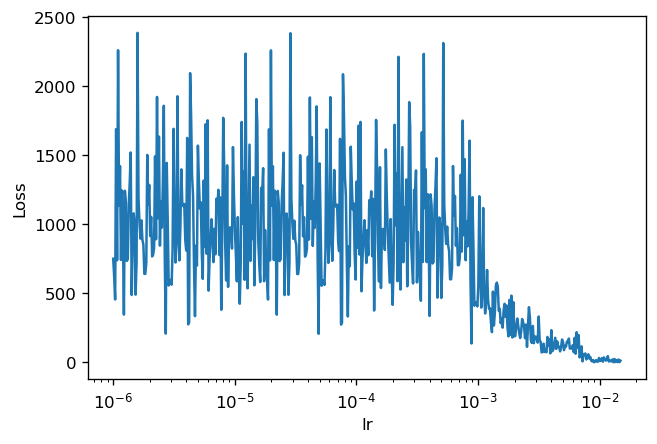

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: slice range here is actually [0, 1], because it's kinda hard to slice the normal way

In [23]:
l = newL(); l.ParamFinder.plot(samples=1000)[:0.99]

As advertised, this callback searches for a perfect parameter for the network.

### Loss

In [26]:
l = newL(); l.run(10); l.Loss

Progress:  30%, epoch:  2/10, batch: 155/157, elapsed:   1.79s  Run cancelled: Low loss 1 achieved!.
Saved to autosave-2.pth


Callback `Loss`, use...
- cb.train: for all training losses over all epochs and batches (#epochs * #batches)
- cb.valid: for all validation losses over all epochs and batches (#epochs * #batches)
- cb.plot(): to plot the 2 above
- cb.epoch: for average losses of each epochs
- cb.something: to get specific attribute "something" from learner if not available
- cb.withCheckpoint(checkpoint, f): to quickly insert an event handler
- cb.detach(): to remove itself from its parent Callbacks

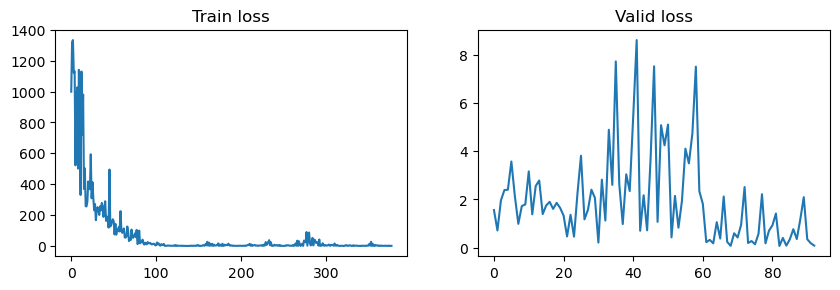

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [27]:
l.Loss.plot()

Data type returned is `k1lib.viz.SliceablePlot`, so you can zoom the plot in a specific range, like this:

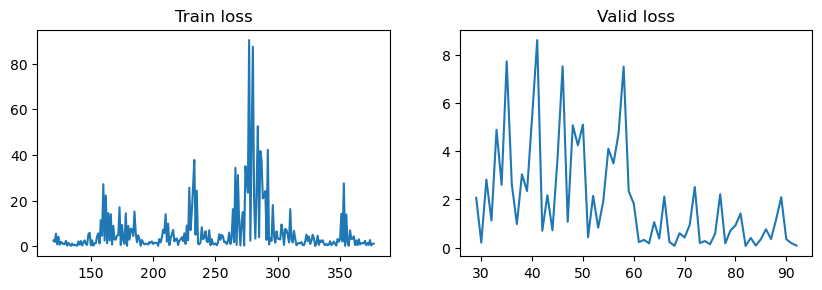

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [28]:
l.Loss.plot()[120:]

Notice how original train range is `[0, 250]`, and valid range is `[0, 60]`. When sliced with `[120:]`, train's range sliced as planned from the middle to end, and valid's range adapting and also sliced from middle to end (`[30:]`).

### LossLandscape


Progress: 100%          8/8 Finished [-3.2, 3.2] range                          

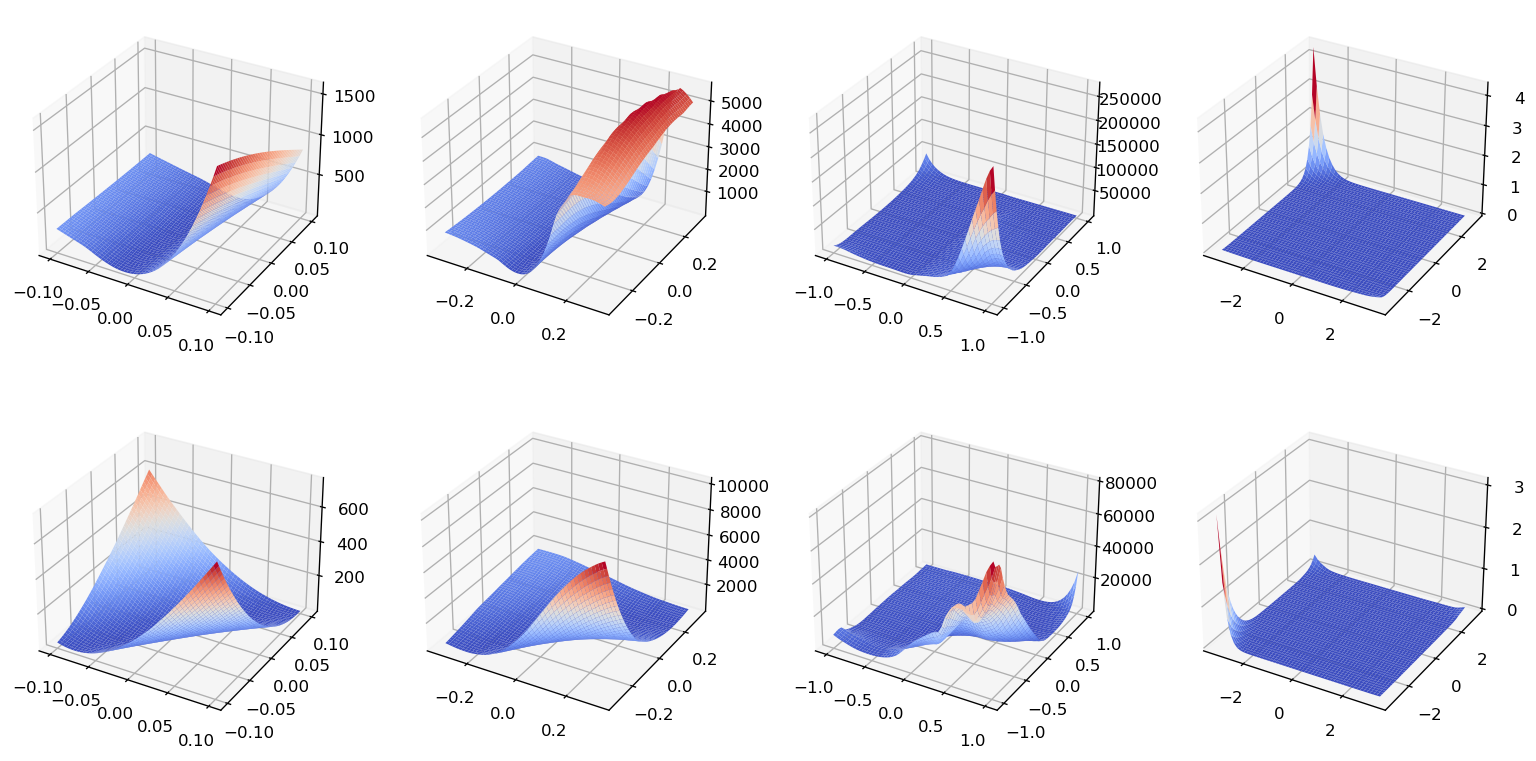

In [55]:
l.LossLandscape.plot()

Oh and yeah, this callback can give you a quick view into how the landscape is. The center point (0, 0) is always the lowest portion of the landscape, so that tells us the network has learned stuff.

### HookParam

In [30]:
l.HookParam

Callback `HookParam`: 6 params, 472 means and stds each:
  0. bulk.2.seq.0.weight
  1. bulk.2.seq.0.bias
  2. bulk.3.seq.0.weight
  3. bulk.3.seq.0.bias
  4. bulk.4.seq.0.weight
  5. bulk.4.seq.0.bias

Use...
- cb.plot(): to quickly look at everything
- cb[i]: to view a single param
- cb[a:b]: to get a new HookParam with selected params
- cb.something: to get specific attribute "something" from learner if not available
- cb.withCheckpoint(checkpoint, f): to quickly insert an event handler
- cb.detach(): to remove itself from its parent Callbacks

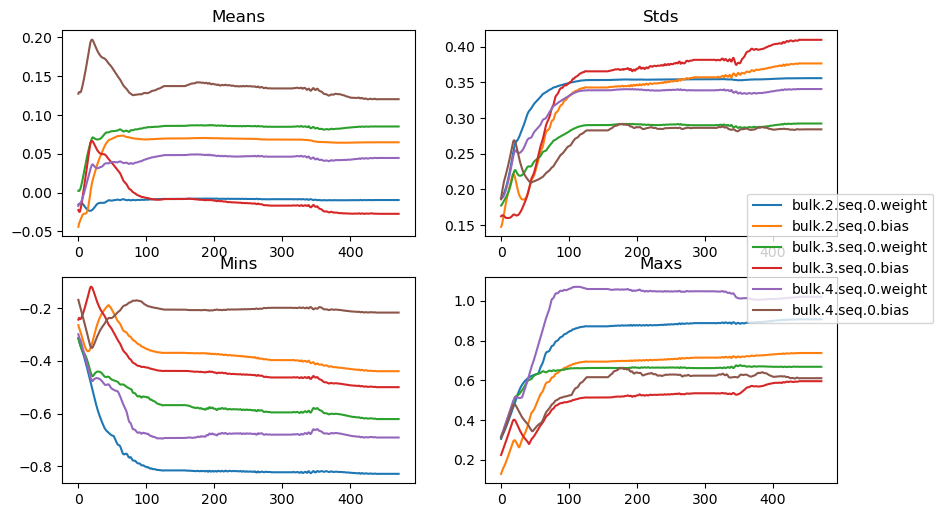

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [29]:
l.HookParam.plot()

This tracks parameters' means, stds, mins and maxs while training. You can also display only certain number of parameters:

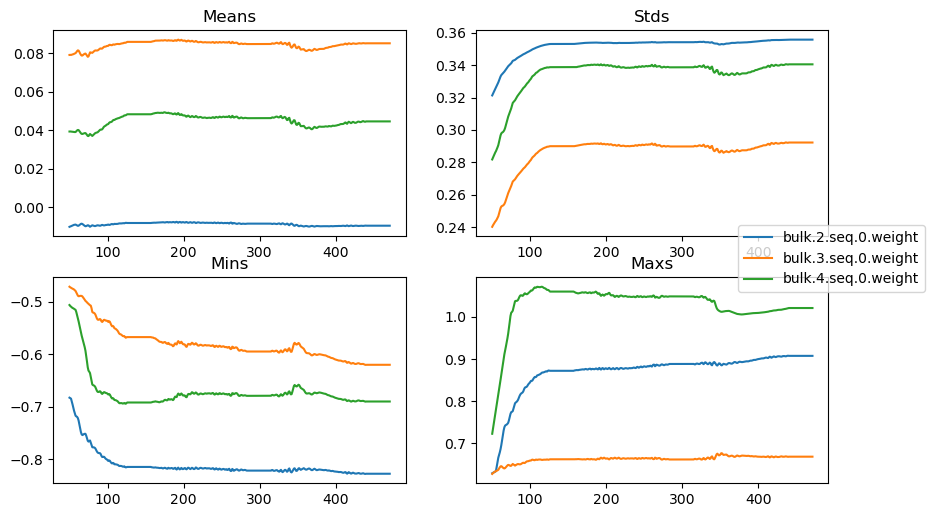

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [31]:
l.HookParam[::2].plot()[50:]

### HookModule

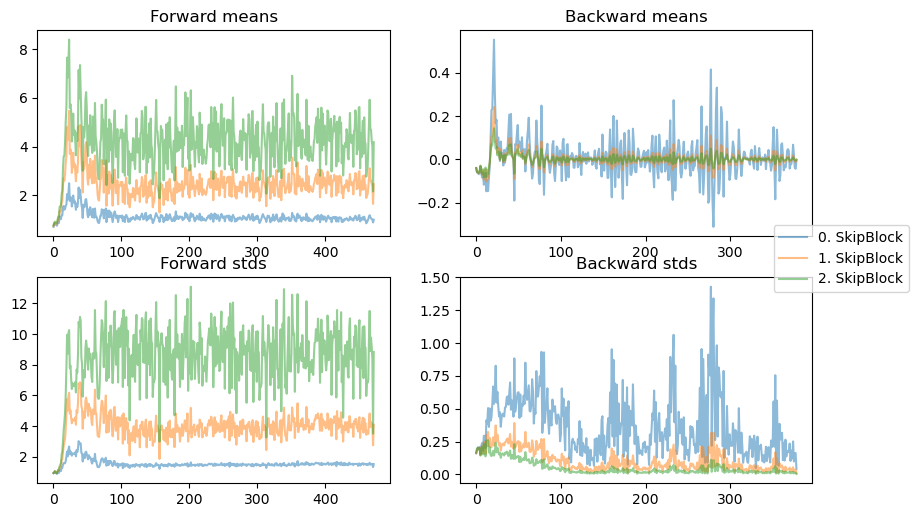

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [32]:
l.HookModule.plot()

Pretty much same thing as before. This callback hooks into selected modules, and captures the forward and backward passes. Both `HookParam` and `HookModule` will only hook into selected modules (by default all is selected):

In [42]:
l.moduleSelector

ModuleSelector:
root: Network                     
    bulk: Sequential                     
        0: Linear                         
        1: LeakyReLU                         
        2: SkipBlock                     HookModule
            seq: Sequential                     
                0: Linear                     HookParam    
                1: LeakyReLU                         
                2: Linear                         
                3: LeakyReLU                         
                4: Linear                         
                5: LeakyReLU                         
        3: SkipBlock                     HookModule
            seq: Sequential                     
                0: Linear                     HookParam    
                1: LeakyReLU                         
                2: Linear                         
                3: LeakyReLU                         
                4: Linear                         
                5: Lea

## CSS module selector

You can select specific modules by setting `l.css = ...`, kinda like this:

In [48]:
l = newL()
l.css = """
#bulk > Linear: a
#bulk > #1: b
SkipBlock Sequential: c
SkipBlock LeakyReLU
"""
l.moduleSelector

ModuleSelector:
root: Network                     
    bulk: Sequential                     
        0: Linear                     a    
        1: LeakyReLU                     b    
        2: SkipBlock                     
            seq: Sequential                     c
                0: Linear                         
                1: LeakyReLU                     all    
                2: Linear                         
                3: LeakyReLU                     all    
                4: Linear                         
                5: LeakyReLU                     all    
        3: SkipBlock                     
            seq: Sequential                     c
                0: Linear                         
                1: LeakyReLU                     all    
                2: Linear                         
                3: LeakyReLU                     all    
                4: Linear                         
                5: LeakyReLU             

Essentially, you can:
- #a: to select modules with name "a"
- b: to select modules with class name "b"
- a #b: to select modules with name "b" under modules with class "a"
- a > #b: to select modules with name "b" directly under modules with class "a"
- "#a: infinity war": to assign selected module with properties "infinity" and "war"

Different callbacks will recognize certain props. `HookModule` will hook all modules with props "all" or "HookModule". Likewise, `HookParam` will hook all parameters with props "all" or "HookParam".

## Data loader

In [5]:
l.data

`Data` object, just a shell containing 2 `DataLoader`s: `.train` and `.valid`

In [6]:
l.data.train

DataLoader object. 126 batches total, use...
- for data in dl: print(data)
- it = iter(dl); data = next(it)
- len(dl): to get dataloader's length
- dl.sample: to get a sample of the data

In [7]:
l.data.train.sample

(tensor([ 4.4688, -4.8750, -0.5430, -0.5977,  0.0708,  2.2188, -2.6094,  1.1094,
         -2.1562,  2.7188, -1.9297, -3.3750, -4.6250, -0.9023,  1.2812,  3.0312,
          4.7812, -4.1875, -1.7344, -4.3438,  0.3633,  3.1562,  0.0391,  3.3281,
         -4.7812, -1.9297, -2.2969,  1.6406,  0.7031, -3.5781,  0.7852,  2.7812,
          3.9531,  4.4688, -4.8125, -2.2812, -0.2617,  2.5469,  4.8750, -3.3594,
         -2.2500, -1.0469,  4.2812,  2.1875, -4.3750,  3.2812,  0.6367, -4.8438,
         -0.9531, -4.1562,  3.8906,  0.6992, -4.1875,  4.0312, -2.8906, -2.9062,
         -2.7500, -4.9062,  2.9062, -4.8750, -1.5234,  0.3652,  4.2188,  1.4766],
        dtype=torch.bfloat16),
 tensor([8.7000e+01, 7.5378e-03, 5.8203e-01, 5.5078e-01, 1.0703e+00, 9.1875e+00,
         7.3730e-02, 3.0469e+00, 1.1475e-01, 1.5250e+01, 1.4551e-01, 3.4180e-02,
         9.8877e-03, 4.0625e-01, 3.6094e+00, 2.0875e+01, 1.2000e+02, 1.5381e-02,
         1.7676e-01, 1.2939e-02, 1.4375e+00, 2.3625e+01, 1.0391e+00, 2.7750e+

It's simple, really! `l.data` contains a `train` and `valid` data loader. Each has multiple ways to unpack values, and you even can get a quick sample of it.

## Callbacks

Let's look at `l` again:

In [8]:
l

l.model:
    Network(
      (bulk): Sequential(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): SkipBlock(
          (seq): Sequential(
            (0): Linear(in_features=10, out_features=10, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=10, out_features=10, bias=True)
            (3): LeakyReLU(negative_slope=0.01)
    .....
l.opt:
    Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        eps: 1e-08
        lr: 0.01
        weight_decay: 0
    )
l.cbs:
    Callbacks:
    - ProgressBar
    - DontTrainValid
    - Autosave
    - LossLandscape
    - HookModule
    - HookParam
    - ModifyBatch
    - DType
    - CancelOnLowLoss
    .....
Use...
- l.model = ...: to specify a nn.Module object
- l.data = ...: to specify data object
- l.opt = ...: to specify an optimizer
- l.lossF = ...: to specify a loss function
- l.css = ...: to select m

`l.model` and `l.opt` is simple enough. It's just PyTorch's primitives. The part where most of the magic lies is in `l.cbs`, an object of type `k1lib.Callbacks`, a container object of `k1lib.Callback`. Notice the final "s" in the name.

A callback is pretty simple. While training, you may want to sort of insert functionality here and there. Let's say you want the program to print out a progress bar after each epoch. You can edit the learning loop directly, with some internal variables to keep track of the current epoch and batch, like this:

```python
startTime = time.time()
for epoch in epochs:
    for batch in batches:
        # do training
        data = getData()
        train(data)
        
        # calculate progress
        elapsedTime = time.time() - startTime
        progress = round((batch / batches + epoch) / epochs * 100)
        print(f"\rProgress: {progress}%, elapsed: {round(elapsedTime, 2)}s         ", end="")
```

But this means when you don't want that functionality anymore, you have to know what internal variable belongs to the progress bar, and you have to delete it. With callbacks, things work a little bit differently:

```python
class ProgressBar(k1lib.Callback):
    def startRun(self):
        pass
    def startBatch(self):
        self.progress = round((self.batch / self.batches + self.epoch) / self.epochs * 100)
        a = f"Progress: {self.progress}%"
        b = f"epoch: {self.epoch}/{self.epochs}"
        c = f"batch: {self.batch}/{self.batches}"
        print(f"{a}, {b}, {c}")

class Learner:
    def run(self):
        self.epochs = 1; self.batches = 10

        self.cbs = k1lib.Callbacks()
        self.cbs.append(ProgressBar())

        self.cbs("startRun")
        for self.epoch in self.epochs:
            self.cbs("startEpoch")
            for self.batch in self.batches:
                self.xb, self.yb = getData()
                self.cbs("startBatch")

                # do training
                self.y = self.model(data); self.cbs("endPass")
                self.loss = self.lossF(self.y); self.cbs("endLoss")
                if self.cbs("startBackward"): self.loss.backward()

                self.cbs("endBatch")
            self.cbs("endEpoch")
        self.cbs("endRun")
```

This is a stripped down version of `k1lib.Learner`, to get the idea across. Point is, whenever you do `self.cbs("startRun")`, it will run through all `k1lib.Callback` that it has (`ProgressBar` in this example), check if it implements `startRun`, and if yes, executes it.

Inside `ProgressBar`'s `startBatch`, you can access learner's current epoch by doing `self.learner.epoch`. But you can also do `self.epoch` alone. If the attribute is not defined, then it will automatically be searched inside `self.learner`.

As you can see, if you want to get rid of the progress bar without using `k1lib.Callbacks`, you have to delete the `startTime` line and the actual calculate progress lines. This requires you to remember which lines belongs to which functionality. If you use the `k1lib.Callbacks` mechanism instead, then you can just uncomment `self.cbs.append(ProgressBar())`, and that's it. This makes swapping out components extremely easy, repeatable, and beautiful.

Other use cases include intercepting at `startBatch`, and push all the training data to the GPU. You can also reshape the data however you want. You can insert different loss mechanisms (`endLoss`) in addition to `lossF`, or quickly inspect the model output. You can also change learning rates while training (`startEpoch`) according to some schedules. The possibility are literally endless.